# Loading Data

In [ ]:
!kaggle datasets download -d kongaevans/speaker-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset
License(s): unknown
 98% 227M/231M [00:06<00:00, 43.0MB/s]
100% 231M/231M [00:06<00:00, 37.4MB/s]


In [ ]:
!unzip /content/speaker-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/556.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/557.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/558.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/559.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/56.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/560.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/561.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/562.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/563.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/564.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/565.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/566.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/567.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/568.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/569.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/57.wav  
  infla

In [ ]:
import os
import csv

# Set the base folder path
base_folder = '/content/16000_pcm_speeches'  # Change this to the path of your folder

# Set the output CSV file name
output_csv = 'dataset.csv'  # Change this to your desired output CSV file name

# List to store audio file paths and labels
audio_files = []

# Traverse the directory structure
for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(('.mp3', '.wav', '.flac', '.aac')):  # Add more audio file extensions if needed
            file_path = os.path.join(root, file)
            label = os.path.basename(root)  # Assuming the label is the folder name
            audio_files.append((file_path, label))

# Write the paths and labels to a CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Audio Path', 'label'])
    for audio_file in audio_files:
        writer.writerow(audio_file)

print(f"CSV file '{output_csv}' has been created with paths and labels of audio files.")


CSV file 'dataset.csv' has been created with paths and labels of audio files.


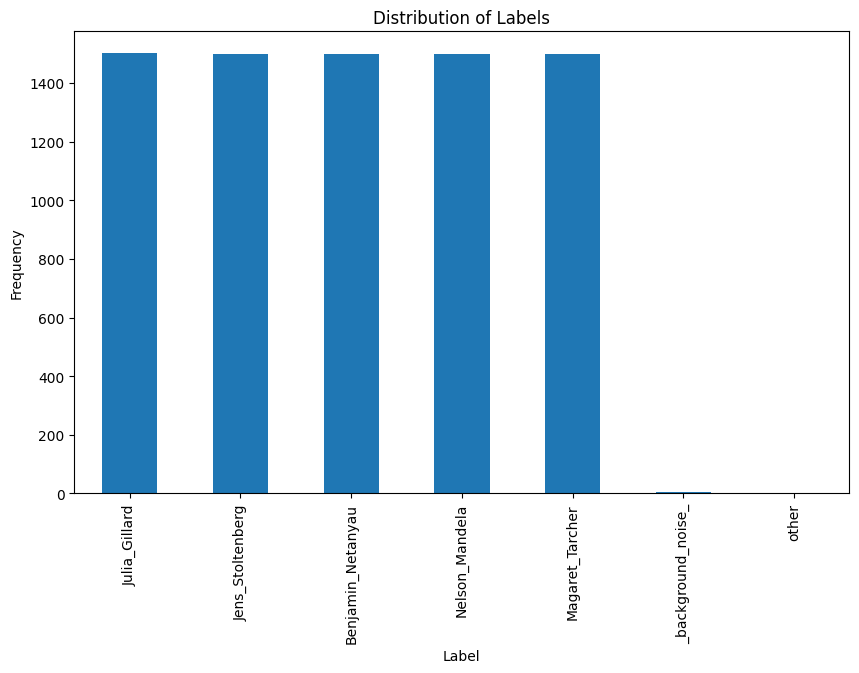

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("dataset.csv")

# Create histogram for 'label' column
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [1]:
import numpy as np

def train_test_split1(X, y, test_size=0.25, random_state=None):

    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Ensure consistent random state
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Determine the size of the test set
    if isinstance(test_size, float):
        test_size = int(test_size * X.shape[0])
    elif isinstance(test_size, int):
        test_size = test_size
    else:
        raise ValueError("test_size should be a float or an int")

    # Split the indices for training and testing
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Split the data
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test



In [2]:
import numpy as np

class StandardScaler1:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):

        X = np.array(X)
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=0)

    def transform(self, X):

        X = np.array(X)
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)



# Using ZCR, Spectral Centroid and RMS

In [12]:
import os
import librosa
import numpy as np
import concurrent.futures
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Function to extract features from an audio file
def feature_extractor(audio_file,sr=8000):
    y, sr = librosa.load(audio_file)
    y, _ = librosa.effects.trim(y)  # Remove leading and trailing silence
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    return np.mean(zero_crossing_rate), np.mean(rms), np.mean(spectral_centroid)

# Function to extract features sequentially
def extract_features_sequential(X):
    start_time = time.time()
    features = [feature_extractor(audio_file) for audio_file in X]
    end_time = time.time()
    execution_time = end_time - start_time
    return features, execution_time

# Function to extract features in parallel
def extract_features_parallel(X):
    start_time = time.time()
    with ThreadPoolExecutor(max_workers=256) as executor:
        # Map the feature extraction function to each audio file in X
        features = list(executor.map(feature_extractor, X))
    end_time = time.time()
    execution_time = end_time - start_time
    return features, execution_time

# Read the CSV file
df = pd.read_csv("dataset.csv")
labels_to_drop = ["_background_noise_", "other"]

# Drop rows with the specific labels
df = df[~df['label'].isin(labels_to_drop)]

# Extract audio file paths and labels from the DataFrame
X = df['Audio Path'].tolist()
Y = df["label"].tolist()

# Sequential extraction
features_sequential, time_sequential = extract_features_sequential(X)
print("Sequential execution time:", time_sequential, "seconds")

# Parallel extraction
features_parallel, time_parallel = extract_features_parallel(X)
print("Parallel execution time:", time_parallel, "seconds")


import joblib
start_time = time.time()
n_jobs=32
verbose=1
jobs = [ joblib.delayed(feature_extractor)(i) for i in X ]
features_parallel = joblib.Parallel(n_jobs=n_jobs, verbose=verbose)(jobs)
end_time = time.time()
time_parallel= end_time - start_time
print("Parallel execution time:", time_parallel, "seconds")

Sequential execution time: 105.72517657279968 seconds
Parallel execution time: 32.111114740371704 seconds


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 208 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 708 tasks      | elapsed:    1.9s
[Parallel(n_jobs=32)]: Done 1408 tasks      | elapsed:    3.5s
[Parallel(n_jobs=32)]: Done 2308 tasks      | elapsed:    5.7s
[Parallel(n_jobs=32)]: Done 3408 tasks      | elapsed:    8.2s
[Parallel(n_jobs=32)]: Done 4708 tasks      | elapsed:   11.3s
[Parallel(n_jobs=32)]: Done 6208 tasks      | elapsed:   14.9s


Parallel execution time: 17.855644464492798 seconds


[Parallel(n_jobs=32)]: Done 7438 out of 7501 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=32)]: Done 7501 out of 7501 | elapsed:   17.7s finished


In [13]:

from sklearn.model_selection import train_test_split
# Convert to numpy arrays
X = np.array(features_parallel)
Y = np.array(Y)


# Split data into training and testing sets with an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 6000
Testing set size: 1501


In [14]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score



# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



## Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression
# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7168554297135243
Precision: 0.7204133601248639
Recall: 0.7185213651553558
F1 Score: 0.7179206574806262


Classification Report:
                    precision    recall  f1-score   support

Benjamin_Netanyau       0.62      0.63      0.63       310
 Jens_Stoltenberg       0.76      0.66      0.71       310
    Julia_Gillard       0.64      0.73      0.68       283
  Magaret_Tarcher       0.77      0.81      0.78       283
   Nelson_Mandela       0.82      0.76      0.79       315

         accuracy                           0.72      1501
        macro avg       0.72      0.72      0.72      1501
     weighted avg       0.72      0.72      0.72      1501



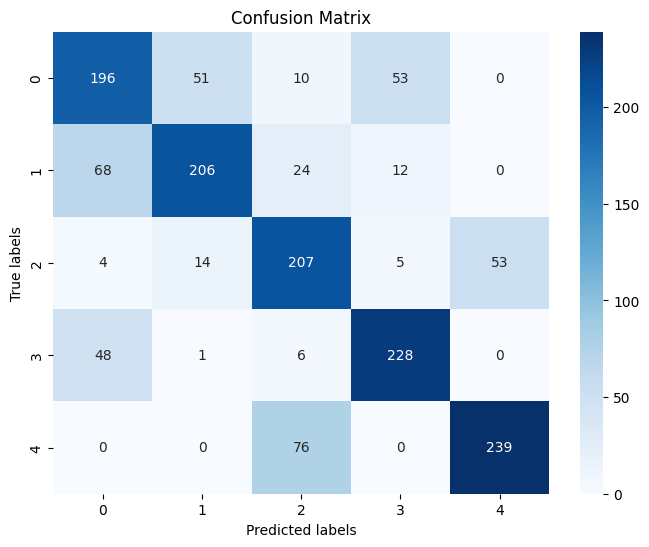

In [16]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## SGDClassifier

In [17]:
from sklearn.linear_model import SGDClassifier
# Initialize Logistic Regression model
model = SGDClassifier(loss='log_loss', max_iter=1000,learning_rate="constant",eta0=0.01)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.692871419053964
Precision: 0.6875211965300865
Recall: 0.6940750752217755
F1 Score: 0.6891910741686189


Classification Report:
                    precision    recall  f1-score   support

Benjamin_Netanyau       0.57      0.48      0.52       310
 Jens_Stoltenberg       0.72      0.70      0.71       310
    Julia_Gillard       0.64      0.65      0.64       283
  Magaret_Tarcher       0.71      0.83      0.77       283
   Nelson_Mandela       0.80      0.81      0.81       315

         accuracy                           0.69      1501
        macro avg       0.69      0.69      0.69      1501
     weighted avg       0.69      0.69      0.69      1501



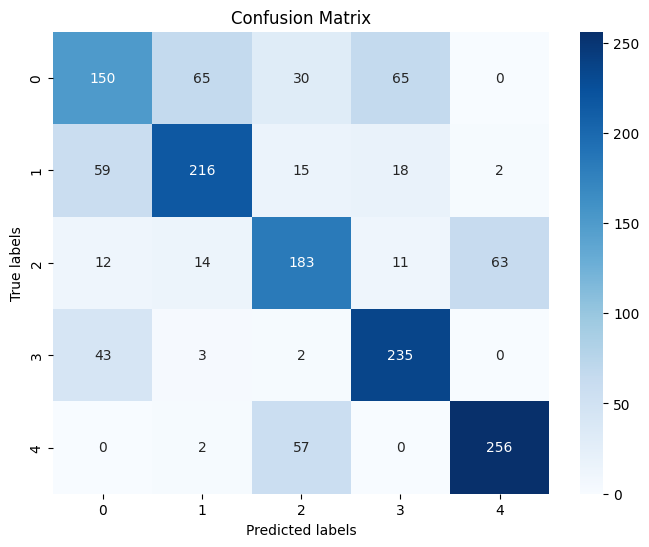

In [18]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## Torch

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Convert the datasets to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train_encoded = torch.tensor(y_train_encoded, dtype=torch.long)  # For multi-class classification
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test_encoded = torch.tensor(y_test_encoded, dtype=torch.long)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)  # No activation, we'll use CrossEntropyLoss which includes softmax

# Initialize the model, define the loss function and the optimizer
input_dim = X_train.shape[1]
output_dim = len(torch.unique(y_train_encoded))  # Number of classes
model = LogisticRegressionModel(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss includes softmax
optimizer = optim.SGD(model.parameters(), lr=0.01)
# Training parameters
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train_encoded)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 1.5386
Epoch [200/1000], Loss: 1.3922
Epoch [300/1000], Loss: 1.2876
Epoch [400/1000], Loss: 1.2126
Epoch [500/1000], Loss: 1.1581
Epoch [600/1000], Loss: 1.1174
Epoch [700/1000], Loss: 1.0862
Epoch [800/1000], Loss: 1.0616
Epoch [900/1000], Loss: 1.0416
Epoch [1000/1000], Loss: 1.0251


Training Accuracy: 56.72%
Test Accuracy: 57.83%
Confusion Matrix:
 [[ 98  55  67  86   4]
 [ 61 187   9  26  27]
 [ 13   7  87  54 122]
 [ 45   5   0 233   0]
 [  0   0  51   1 263]]


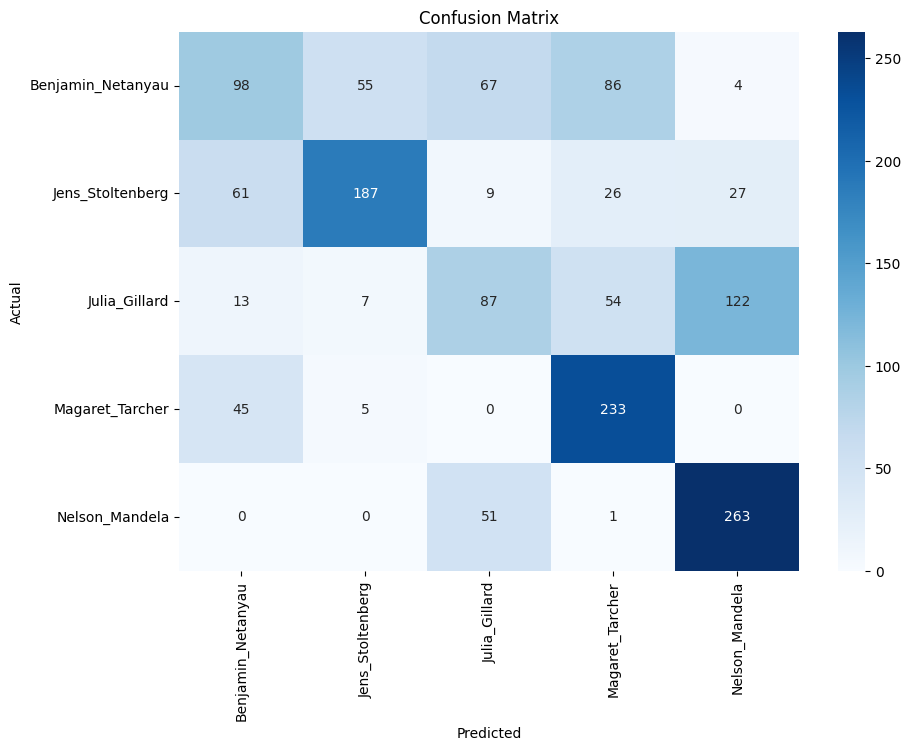

Classification Report:
                    precision    recall  f1-score   support

Benjamin_Netanyau       0.45      0.32      0.37       310
 Jens_Stoltenberg       0.74      0.60      0.66       310
    Julia_Gillard       0.41      0.31      0.35       283
  Magaret_Tarcher       0.58      0.82      0.68       283
   Nelson_Mandela       0.63      0.83      0.72       315

         accuracy                           0.58      1501
        macro avg       0.56      0.58      0.56      1501
     weighted avg       0.56      0.58      0.56      1501



In [21]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients during evaluation
    # Training accuracy
    outputs_train = model(X_train)
    _, predicted_train = torch.max(outputs_train, 1)
    train_accuracy = (predicted_train == y_train_encoded).sum().item() / y_train_encoded.size(0)

    # Test accuracy
    outputs_test = model(X_test)
    _, predicted_test = torch.max(outputs_test, 1)
    test_accuracy = (predicted_test == y_test_encoded).sum().item() / y_test_encoded.size(0)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion matrix and classification report
cm = confusion_matrix(y_test_encoded, predicted_test)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test_encoded, predicted_test, target_names=label_encoder.classes_)
print("Classification Report:\n", report)


# Using MFCC

In [3]:
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
# Function to extract features from an audio file
def mfcc_feature_extractor(audio_file, sr=22050, n_fft=2048, hop_length=512, n_mfcc=13):
    y, sr = librosa.load(audio_file, sr=sr)
    y, _ = librosa.effects.trim(y)  # Remove leading and trailing silence
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean


# Function to extract features in parallel
def mfcc_extract_features_parallel(X):
    start_time = time.time()
    with ThreadPoolExecutor(max_workers=256) as executor:
        # Map the feature extraction function to each audio file in X
        features = list(executor.map(mfcc_feature_extractor, X))
    end_time = time.time()
    execution_time = end_time - start_time
    return features, execution_time


def mfcc_extract_features_sequential(X):
    start_time = time.time()
    features = [mfcc_feature_extractor(audio_file) for audio_file in X]
    end_time = time.time()
    execution_time = end_time - start_time
    return features, execution_time

# Example usage
df = pd.read_csv("dataset.csv")
labels_to_drop = ["_background_noise_", "other"]

# Drop rows with the specific labels
df = df[~df['label'].isin(labels_to_drop)]
# Extract audio file paths and labels from the DataFrame
X = df['Audio Path'].tolist()
Y = df["label"].tolist()

# Sequential extraction
features_sequential, time_sequential = mfcc_extract_features_sequential(X)
print("Sequential execution time:", time_sequential, "seconds")

import joblib
start_time = time.time()
n_jobs=32
verbose=1
jobs = [ joblib.delayed(mfcc_feature_extractor)(i) for i in X ]
features_parallel = joblib.Parallel(n_jobs=n_jobs, verbose=verbose)(jobs)
end_time = time.time()
time_parallel= end_time - start_time
print("Parallel execution time:", time_parallel, "seconds")

Sequential execution time: 84.737548828125 seconds


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   12.3s
[Parallel(n_jobs=32)]: Done 575 tasks      | elapsed:   14.2s
[Parallel(n_jobs=32)]: Done 1274 tasks      | elapsed:   17.0s
[Parallel(n_jobs=32)]: Done 2407 tasks      | elapsed:   20.3s
[Parallel(n_jobs=32)]: Done 6793 tasks      | elapsed:   29.2s


Parallel execution time: 39.56319880485535 seconds


[Parallel(n_jobs=32)]: Done 7501 out of 7501 | elapsed:   39.4s finished


In [4]:

from sklearn.model_selection import train_test_split
# Convert to numpy arrays
X = np.array(features_parallel)
Y = np.array(Y)


# Split data into training and testing sets with an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 6000
Testing set size: 1501


## Logistic regression

In [5]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9826782145236509
Precision: 0.9828962189903947
Recall: 0.9825589697104572
F1 Score: 0.982640217676692


C:\Users\Ali\.conda\envs\paper_model\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
                    precision    recall  f1-score   support

Benjamin_Netanyau       0.96      0.99      0.98       310
 Jens_Stoltenberg       0.98      0.96      0.97       310
    Julia_Gillard       0.99      1.00      1.00       283
  Magaret_Tarcher       0.98      0.96      0.97       283
   Nelson_Mandela       1.00      1.00      1.00       315

         accuracy                           0.98      1501
        macro avg       0.98      0.98      0.98      1501
     weighted avg       0.98      0.98      0.98      1501



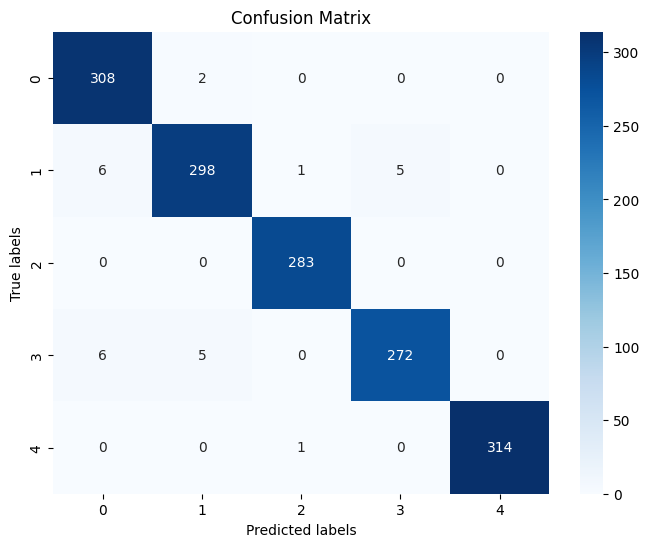

In [6]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## SGDClassifier

In [7]:
from sklearn.linear_model import SGDClassifier
# Initialize Logistic Regression model
model = SGDClassifier(loss='log_loss', max_iter=1000,learning_rate="constant",eta0=0.01)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9347101932045303
Precision: 0.9371301037094376
Recall: 0.9354811570131301
F1 Score: 0.9344588963085151


Classification Report:
                    precision    recall  f1-score   support

Benjamin_Netanyau       0.98      0.88      0.93       310
 Jens_Stoltenberg       0.94      0.96      0.95       310
    Julia_Gillard       0.92      0.93      0.92       283
  Magaret_Tarcher       0.85      0.98      0.91       283
   Nelson_Mandela       1.00      0.92      0.96       315

         accuracy                           0.93      1501
        macro avg       0.94      0.94      0.93      1501
     weighted avg       0.94      0.93      0.94      1501



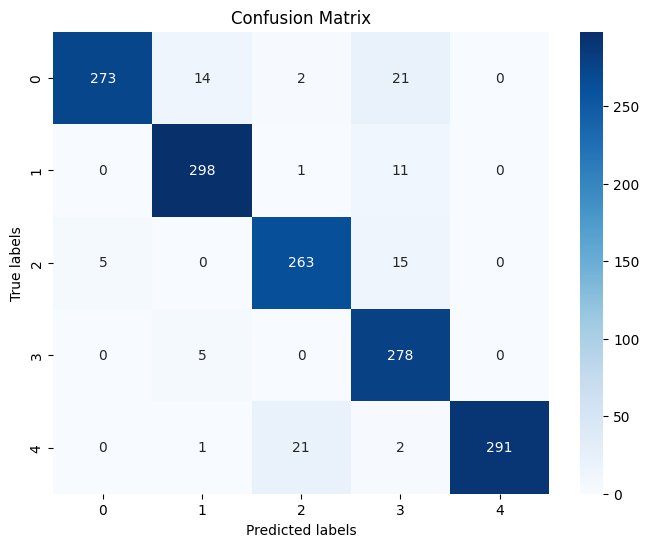

In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification report
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## Torch

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Convert the datasets to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train_encoded = torch.tensor(y_train_encoded, dtype=torch.long)  # For multi-class classification
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test_encoded = torch.tensor(y_test_encoded, dtype=torch.long)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)  # No activation, we'll use CrossEntropyLoss which includes softmax

# Initialize the model, define the loss function and the optimizer
input_dim = X_train.shape[1]
output_dim = len(torch.unique(y_train_encoded))  # Number of classes
model = LogisticRegressionModel(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss includes softmax
optimizer = optim.SGD(model.parameters(), lr=0.01)
# Training parameters
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train_encoded)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 11.1961
Epoch [200/1000], Loss: 5.7638
Epoch [300/1000], Loss: 2.0533
Epoch [400/1000], Loss: 0.6512
Epoch [500/1000], Loss: 0.5523
Epoch [600/1000], Loss: 0.4799
Epoch [700/1000], Loss: 0.4368
Epoch [800/1000], Loss: 0.3985
Epoch [900/1000], Loss: 0.3647
Epoch [1000/1000], Loss: 0.3384


Training Accuracy: 96.37%
Test Accuracy: 96.47%
Confusion Matrix:
 [[299  10   0   1   0]
 [  4 299   2   5   0]
 [  6   0 275   0   2]
 [  8  12   0 263   0]
 [  0   0   3   0 312]]


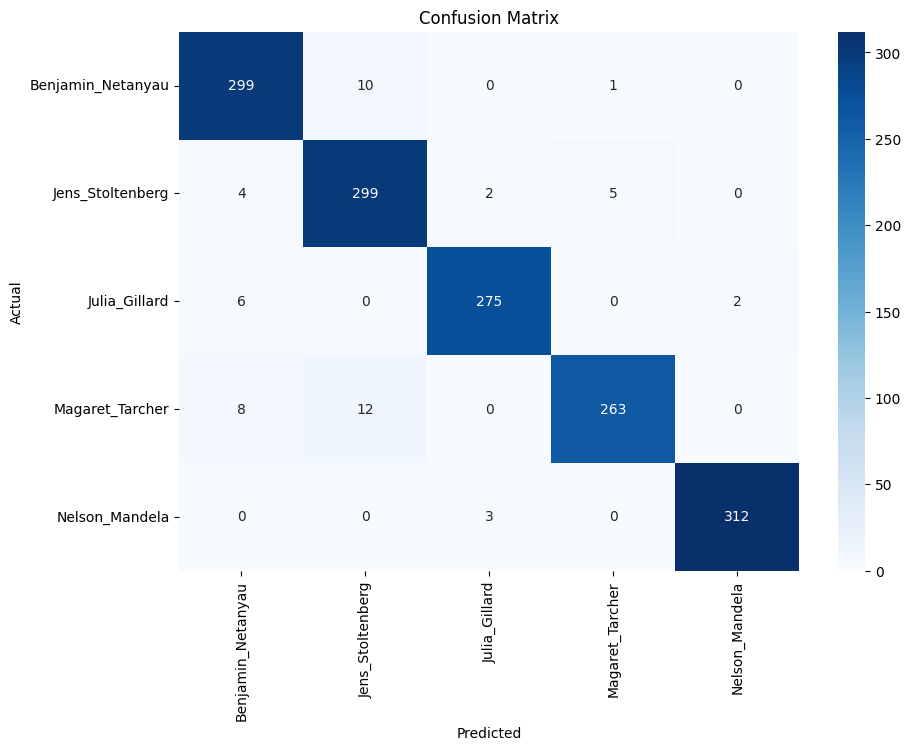

Classification Report:
                    precision    recall  f1-score   support

Benjamin_Netanyau       0.94      0.96      0.95       310
 Jens_Stoltenberg       0.93      0.96      0.95       310
    Julia_Gillard       0.98      0.97      0.98       283
  Magaret_Tarcher       0.98      0.93      0.95       283
   Nelson_Mandela       0.99      0.99      0.99       315

         accuracy                           0.96      1501
        macro avg       0.97      0.96      0.96      1501
     weighted avg       0.97      0.96      0.96      1501



In [11]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients during evaluation
    # Training accuracy
    outputs_train = model(X_train)
    _, predicted_train = torch.max(outputs_train, 1)
    train_accuracy = (predicted_train == y_train_encoded).sum().item() / y_train_encoded.size(0)

    # Test accuracy
    outputs_test = model(X_test)
    _, predicted_test = torch.max(outputs_test, 1)
    test_accuracy = (predicted_test == y_test_encoded).sum().item() / y_test_encoded.size(0)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion matrix and classification report
cm = confusion_matrix(y_test_encoded, predicted_test)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test_encoded, predicted_test, target_names=label_encoder.classes_)
print("Classification Report:\n", report)
